In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [96]:
def extract_date(df, date_col):
    df.copy(deep=True)
    df['hour'] = df[date_col].dt.hour
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['week'] = df[date_col].dt.week
    df['day'] = df[date_col].dt.dayofyear
    return df 

### Load Hourly MEFs from Simple Dispatch Model

In [251]:
df_2017 = pd.read_csv('simple_dispatch_mef/final_mefs_PJM_2017.csv', parse_dates = [1])
df_2016 = pd.read_csv('simple_dispatch_mef/final_mefs_PJM_2016.csv', parse_dates = [1])

In [254]:
#df_2017 = df_2017[['datetime', 'demand','co2_marg']]

# Drop outliers
df_2017 = df_2017[df_2017.co2_marg < 2000]

df_2017.describe()

df_2017 = extract_date(df_2017, 'datetime')

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [120]:
df_2017_head = df_2017.head(100)

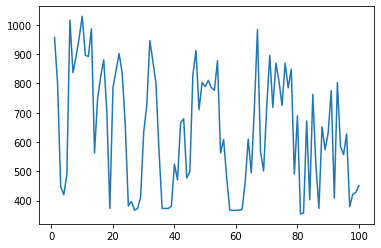

In [121]:
plt.plot(df_2017_head['co2_marg'])

### Quickly Check that Data Makes Sense Against Regression MEFs

##### Monthly MEFs

In [122]:
monthly_mefs = df_2017.groupby( ['month'] ).mean().reset_index()
regression_monthly = pd.read_csv('regression_mef/monthly_mef.csv')

# Look at 2017 data only 
regression_monthly_2017 = regression_monthly.loc[regression_monthly['year'] == 2017]
regression_monthly_2017 = regression_monthly_2017[['month', 'factor']]

regression_monthly_2017 = regression_monthly_2017.merge(monthly_mefs, how='inner', on=['month'])

regression_monthly_2017=regression_monthly_2017.rename(columns = {'factor':'regression', 'co2_marg': 'simple_dispatch'})

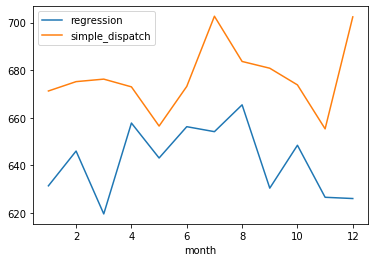

In [124]:
regression_monthly_2017.plot(x="month", y=["regression", "simple_dispatch"], kind="line")


##### Hourly MEFs

In [125]:
hourly_mefs = df_2017.groupby( ['hour'] ).mean().reset_index()
regression_hourly = pd.read_csv('regression_mef/2017_hourly_mef.csv')

# Look at 2017 data only 
regression_hourly = regression_hourly[['hour', 'factor']]

regression_hourly = regression_hourly.merge(hourly_mefs, how='inner', on=['hour'])

regression_hourly = regression_hourly.rename(columns = {'factor':'regression', 'co2_marg': 'simple_dispatch'})


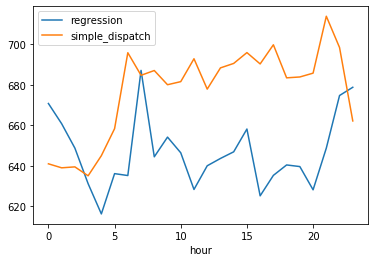

In [126]:
regression_hourly.plot(x="hour", y=["regression", "simple_dispatch"], kind="line")

### Thomas' Suggested Predicted Method
Take the previous 4 week's MEF to create a function and then given demand, create the plot 

In [338]:
predict_week = 50
week_begin = predict_week - 4
week_end = predict_week - 1 

In [339]:
prev_data = df_2017.loc[(df_2017['week'] >= week_begin) & (df_2017['week'] <= week_end)]

In [340]:
sim_sorted = prev_data[['demand', 'datetime', 'coal_mix', 'co2_tot', 'so2_tot', 'nox_tot', 'gen_cost_marg']].sort_values(by='demand').copy()

#### Calculate Rolling Average

In [341]:
sim_sorted['dlow'] = list(scipy.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[0:-p]) + list(scipy.repeat(0, p/2.))
sim_sorted['dhigh'] = list(scipy.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[p:]) + list(scipy.repeat(0, p/2.))
sim_sorted['dd'] = sim_sorted.dhigh - sim_sorted.dlow


/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.repeat is deprecated and will be removed in SciPy 2.0.0, use numpy.repeat instead
  """Entry point for launching an IPython kernel.
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.repeat is deprecated and will be removed in SciPy 2.0.0, use numpy.repeat instead
  


In [267]:
import scipy
import scipy.linalg
import scipy.stats

In [342]:
e = 'co2'
sim_sorted[e+'_tot_rolling'] = sim_sorted[e+'_tot'].rolling(window=p*2, min_periods=p*2, center=True).mean()

sim_sorted[e + 'low'] = list(scipy.repeat(0, p/2.)) + list(sim_sorted[e + '_tot_rolling'].iloc[0:-p]) + list(scipy.repeat(0, p/2.))
sim_sorted[e + 'high'] = list(scipy.repeat(0, p/2.)) + list(sim_sorted[e + '_tot_rolling'].iloc[p:]) + list(scipy.repeat(0, p/2.))
sim_sorted['d'+e] = sim_sorted[e + 'high'] - sim_sorted[e + 'low']
sim_sorted[e+'slope_0'] = scipy.divide(sim_sorted['d'+e], sim_sorted.dd)
sim_sorted[e+'_slope'] = sim_sorted[e+'slope_0'].rolling(window=p, min_periods=p, center=True).mean()
sim_sorted['gen_cost_marg_rolling'] = sim_sorted['gen_cost_marg'].rolling(window=p*2, min_periods=p*2, center=True).mean()

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.repeat is deprecated and will be removed in SciPy 2.0.0, use numpy.repeat instead
  after removing the cwd from sys.path.
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.repeat is deprecated and will be removed in SciPy 2.0.0, use numpy.repeat instead
  """
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.divide is deprecated and will be removed in SciPy 2.0.0, use numpy.divide instead
  import sys


In [343]:
p= 30

sim_sorted['dlow'] = list(scipy.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[0:-p]) + list(scipy.repeat(0, p/2.))
sim_sorted['dhigh'] = list(scipy.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[p:]) + list(scipy.repeat(0, p/2.))
sim_sorted['dd'] = sim_sorted.dhigh - sim_sorted.dlow

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.repeat is deprecated and will be removed in SciPy 2.0.0, use numpy.repeat instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.repeat is deprecated and will be removed in SciPy 2.0.0, use numpy.repeat instead
  after removing the cwd from sys.path.


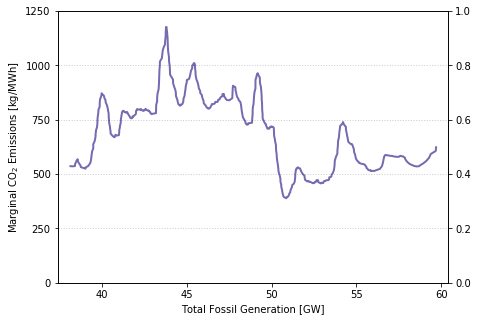

In [287]:
import matplotlib.pylab

#Produces a plot of total fossil generation (x-axis) vs. emissions (y-axis)

#mef / emissions slope plot
f, ax = matplotlib.pylab.subplots(1, figsize=(7,5)) 
ax2 = ax.twinx()
#simulated slopes
ax.plot(sim_sorted[sim_sorted['co2_slope'].notna()]['demand']/1e3, sim_sorted[sim_sorted['co2_slope'].notna()]['co2_slope'], c='#756bb1', lw=2)

#horizontal lines
ax.axhline(250, color='black', alpha=0.2, ls='dotted', linewidth=1)
ax.axhline(500, color='black', alpha=0.2, ls='dotted', linewidth=1)
ax.axhline(750, color='black', alpha=0.2, ls='dotted', linewidth=1)
ax.axhline(1000, color='black', alpha=0.2, ls='dotted', linewidth=1)

#axes limits and labels
ax.set_xlabel('Total Fossil Generation [GW]')
ax.set_ylabel('Marginal CO$_2$ Emissions [kg/MWh]')  

xlim_tuple = (sim_sorted.demand.quantile(0.05)*0.001, sim_sorted.demand.quantile(0.95)*0.001)

ax.set_xlim(xlim_tuple)  
ax.set_ylim(0,1200)
ax.set_yticks([0, 250, 500, 750, 1000, 1250])


In [301]:
line = ax.lines[0]

x = line.get_xdata()
y = line.get_ydata()

#### Make Predictions on the Week

In [313]:
pred_week = df_2017.loc[(df_2017['week'] == 50)]

In [317]:
pred_week['pred'] = np.interp(pred_week['demand']//1e3, x, y)

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


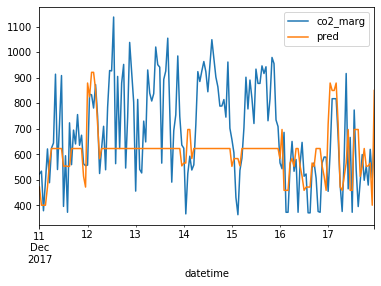

In [324]:
pred_week.plot(x="datetime", y=["co2_marg", "pred"], kind="line")

##### Compare to hourly MEF from all of 2017

In [ ]:
hourly_mefs = df_2017.groupby( ['hour'] ).mean().reset_index()
regression_hourly = pd.read_csv('regression_mef/2017_hourly_mef.csv')

# Look at 2017 data only 
regression_hourly = regression_hourly[['hour', 'factor']]
regression_hourly = regression_hourly.merge(hourly_mefs, how='inner', on=['hour'])
regression_hourly = regression_hourly.rename(columns = {'factor':'regression', 'co2_marg': 'simple_dispatch'})

pred_week_hourly = pred_week.groupby( ['hour'] ).mean().reset_index()
pred_week_hourly = pred_week_hourly[['hour', 'pred']]
regression_hourly = regression_hourly.merge(pred_week_hourly, how='inner', on=['hour'])

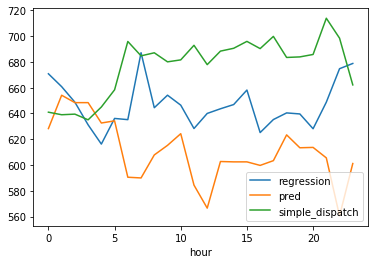

In [337]:
regression_hourly.plot(x="hour", y=["regression", "pred", "simple_dispatch"], kind="line")

### Process Data to Predict MEF Directly with Neural Net

##### Combine Import / Export, Weather, and Demand Data Together

In [215]:
weather_train = pd.read_csv('processed_data/raw_weather_train.csv')
load_data = pd.read_csv('processed_data/load_processed.csv')

features = load_data.merge(weather_train, on = ['year', 'month', 'day'])

In [216]:
co2_marg = pd.concat([df_2017, df_2016], ignore_index=True)
demand = co2_marg[['demand', 'year', 'month', 'day', 'hour']]
target = co2_marg[['co2_marg', 'year', 'month', 'day', 'hour']]

In [217]:
# Pivot so this is by hour
target = target.pivot_table(index = ['year','month', 'day'], columns="hour", values=['co2_marg'])
target.columns = target.columns.map('{0[0]}|{0[1]}'.format)

# Pivot so this is by hour
demand = demand.pivot_table(index = ['year','month', 'day'], columns="hour", values=['demand'])
demand.columns = demand.columns.map('{0[0]}|{0[1]}'.format)

features = features.merge(demand, on = ['year', 'month', 'day'])

# Remove columns that start with PJM (because that represents PJM demand data, which is currently duplicated)
features = features.loc[:,~features.columns.str.startswith('PJM')]

In [218]:
features = features.set_index(['year', 'month', 'day'])

target = target.reset_index()
target = target.set_index(['year', 'month', 'day'])

target = target.dropna()

In [219]:
# Drop extra rows in target 
indx = target.index.difference(features.index)
target = target.drop(indx)

In [225]:
# Drop extra rows in features 
indx = features.index.difference(target.index)
features = features.drop(indx)

In [243]:
target.index

MultiIndex([(2016,  1,   2),
            (2016,  1,   3),
            (2016,  1,   4),
            (2016,  1,   5),
            (2016,  1,   6),
            (2016,  1,   7),
            (2016,  1,   8),
            (2016,  1,   9),
            (2016,  1,  10),
            (2016,  1,  11),
            ...
            (2017, 12, 355),
            (2017, 12, 356),
            (2017, 12, 357),
            (2017, 12, 358),
            (2017, 12, 359),
            (2017, 12, 360),
            (2017, 12, 361),
            (2017, 12, 362),
            (2017, 12, 363),
            (2017, 12, 364)],
           names=['year', 'month', 'day'], length=712)

### Train / Test Split

In [228]:
def split(df):
    # 80-20 split 
    df = df.copy()
    
    train_pct_index = int(0.8 * len(df))
    X_train, X_test = df[:train_pct_index], df[train_pct_index:]

    return X_train, X_test

In [245]:
Y, Y_test1 = split(target)

In [249]:
Y_test1.to_csv("predict_simple_dispatch/test_index.csv")

In [229]:
X_train, X_test = split(features)
Y_train, Y_test = split(target)

### Circular Encoding

In [232]:
# Circular encoding of day of year and month 
def sin_cos_correction(df):
    df = df.reset_index()
    
    df['day_sin'] = np.sin((df['day']-1)*(2.*np.pi/365))
    df['day_cos'] = np.cos((df['day']-1)*(2.*np.pi/365))
    df['month_sin'] = np.sin((df['month']-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df['month']-1)*(2.*np.pi/12))
    
    df = df.drop(['month', 'day'], axis=1)
    df = df.set_index(['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos'])
    return df

In [233]:
X_train = sin_cos_correction(X_train)
X_test = sin_cos_correction(X_test)

In [234]:
Y_train = sin_cos_correction(Y_train)
Y_test = sin_cos_correction(Y_test)

### Standardize

In [240]:
# Standardize features 
scaler = StandardScaler()
scaler.fit(X_train.values) # fit on training set 

scaled_X_train = scaler.transform(X_train.values)
scaled_X_test = scaler.transform(X_test.values)

# Convert back to df after scaling 
X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=X_test.columns)

In [241]:
X_train.to_csv("predict_simple_dispatch/X_Train.csv")
X_test.to_csv("predict_simple_dispatch/X_Test.csv")

In [242]:
Y_train.to_csv("predict_simple_dispatch/Y_train.csv")
Y_test.to_csv("predict_simple_dispatch/Y_test.csv")